In [71]:
!pip install unidecode

In [166]:
import json

# read file
with open('conala-train.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

train_intent_list = []
for i in range(len(obj)):
    train_intent_list.append(obj[i]['intent'])

train_snipet_list = []
for i in range(len(obj)):
    train_snipet_list.append(obj[i]['snippet'])

train_question_id_list = []
for i in range(len(obj)):
    train_question_id_list.append(obj[i]['question_id'])


In [167]:
train_intent_list[-1]

'Convert a string to datetime object in python'

In [168]:
train_snipet_list[-1]

"dateobj = datetime.datetime.strptime(datestr, '%Y-%m-%d').date()"

In [169]:
for item in range(len(train_snipet_list)):
    train_snipet_list[item] = " "+train_snipet_list[item]+" "

In [170]:
import numpy as np
import typing
from typing import Any, Tuple
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.translate.bleu_score import corpus_bleu

In [171]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [172]:
train_source_list = np.array(train_intent_list)

In [173]:
train_target_list = np.array(train_snipet_list)

In [174]:
train_source_list[:5]

array(['How to convert a list of multiple integers into a single integer?',
       'How to convert a list of multiple integers into a single integer?',
       'how to convert a datetime string back to datetime object?',
       'Averaging the values in a dictionary based on the key',
       'zip lists in python'], dtype='<U122')

In [175]:
train_target_list[:5]

array([' sum(d * 10 ** i for i, d in enumerate(x[::-1])) ',
       " r = int(''.join(map(str, x))) ",
       " datetime.strptime('2010-11-13 10:33:54.227806', '%Y-%m-%d %H:%M:%S.%f') ",
       ' [(i, sum(j) / len(j)) for i, j in list(d.items())] ',
       ' zip([1, 2], [3, 4]) '], dtype='<U234')

In [176]:
is_train = np.random.uniform(size=(len(train_source_list),)) < 0.8

In [177]:
is_train[:5]

array([ True, False,  True,  True,  True])

In [178]:
len(is_train)

2379

In [179]:
len(train_source_list)

2379

In [180]:
BUFFER_SIZE = len(train_source_list)
BATCH_SIZE = 20
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_source_list[is_train], train_target_list[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_source_list[~is_train], train_target_list[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [181]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'How can I sum the product of two list items using for loop in python?'
 b'Python - How to call bash commands with pipe?'
 b'Get max key in dictionary' b'Add to integers in a list'
 b'declare an array'], shape=(5,), dtype=string)

tf.Tensor(
[b' sum(x * y for x, y in zip(a, b)) '
 b" subprocess.call('tar c my_dir | md5sum', shell=True) "
 b' max(list(MyCount.keys()), key=int) ' b' foo.append([8, 7]) '
 b' variable = [] '], shape=(5,), dtype=string)


In [182]:
example_text = tf.constant(train_source_list[444])

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'How can I split and parse a string in Python?'
b'How can I split and parse a string in Python?'


In [183]:
example_text = tf.constant(train_snipet_list[444])

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b' """2.7.0_bf4fda703454""".split(\'_\') '
b' """2.7.0_bf4fda703454""".split(\'_\') '


In [184]:
train_intent_list[444]

'How can I split and parse a string in Python?'

In [185]:
train_snipet_list[444]

' """2.7.0_bf4fda703454""".split(\'_\') '

In [186]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [187]:
def target_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text)
  text = tf.strings.join(['[START]', text, '[END]'])
  return text

In [188]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

 """2.7.0_bf4fda703454""".split('_') 
[START] .  . bffda . split [END]


In [189]:
max_vocab_size = 1000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [190]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'a', 'in', 'python', 'to', 'how', 'of']

In [191]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=target_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
len(target_text_processor.get_vocabulary())

1000

In [192]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 8, 32, 17, 107, 13, 415, 9, 36, 11, 100, 25, 47, 165, 5, 6, 10, 3],
 [2, 6, 8, 7, 308, 253, 549, 15, 655, 10, 3], [2, 19, 270, 59, 5, 18, 3]]>

In [193]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[10].numpy()]
' '.join(tokens)

'[START] regex match [UNK] number of letters [END]'

In [194]:
print(example_tokens[10].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(8,), dtype=int64, numpy=array([  2,  56, 146,   1,  39,   9, 273,   3], dtype=int64)>>


In [195]:
target_vocab = np.array(target_text_processor.get_vocabulary())
tokens = target_vocab[example_tokens[1].numpy()]
' '.join(tokens)

'[START] = if x values)) Key\': 5]) pass {0}""".format(\'today\') x: [END]'

Text(0.5, 1.0, 'Mask')

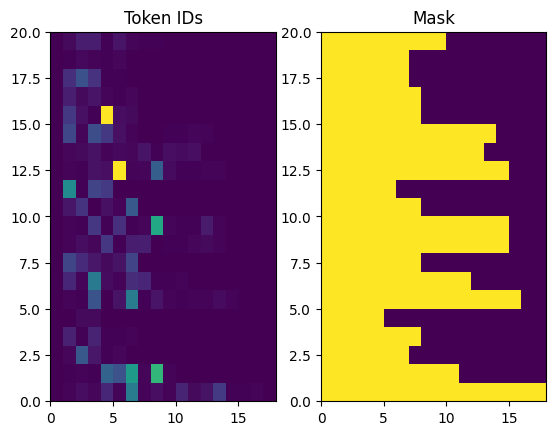

In [196]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [197]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [198]:
#Here is first sequence of each bach
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2 373  31   3   0   0   0   0   0   0]

[ 2  1 11  1  0  0  0  0  0  0]
[ 1 11  1  3  0  0  0  0  0  0]


In [199]:
UNITS = 256

In [200]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [201]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (20, 21)
Encoder output, shape (batch, s, units): (20, 21, 256)


In [202]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [203]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (20, 21, 256)
Target sequence, shape (batch, t, units): (20, 12, 256)
Attention result, shape (batch, t, units): (20, 12, 256)
Attention weights, shape (batch, t, s):    (20, 12, 21)


In [204]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

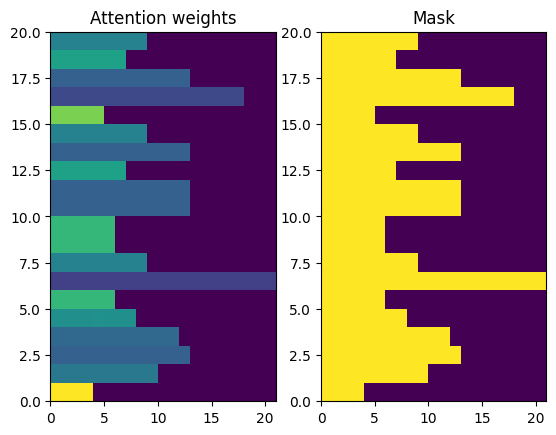

In [205]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [206]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [207]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [208]:
decoder = Decoder(target_text_processor, UNITS)

In [209]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (20, 21, 256)
input target tokens shape: (batch, t) (20, 12)
logits shape shape: (batch, target_vocabulary_size) (20, 12, 1000)


In [210]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [211]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [212]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [213]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b"subprocess.call(['shutdown', style='o') axis=1, r sum(my_counter.values()) 1]]) values)) INTO  ",
       b"shutil.copy2('/dir/file.ext', def table sublist) df2.values, (letter, y, style='width=300px;') urllib.parse.unquote(url).decode('utf8') e",
       b"i: v.lower()) string_slice.split(':')]) user.groups.filter(name='Member').exists() list(zip(a, x[:2] -c list(d.items()) sum([True, :]"],
      dtype=object)

In [214]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [215]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (20, 21)
Target tokens, shape: (batch, t) (20, 12)
logits, shape: (batch, t, target_vocabulary_size) (20, 12, 1000)


In [216]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [217]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [218]:
#Configuring model for training:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [219]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 6.9077554, 'expected_acc': 0.001}

In [220]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 4s 13ms/step - loss: 6.8598 - masked_acc: 0.0000e+00 - masked_loss: 6.8598


{'loss': 6.859816074371338,
 'masked_acc': 0.0,
 'masked_loss': 6.859816074371338}

In [221]:
history = model.fit(
    train_ds.repeat(), 
    epochs=10,
    steps_per_epoch = 20,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
20/20 [==============================] - 8s 84ms/step - loss: 4.2026 - masked_acc: 0.3461 - masked_loss: 4.2026 - val_loss: 2.8117 - val_masked_acc: 0.4256 - val_masked_loss: 2.8117
Epoch 2/10
20/20 [==============================] - 2s 91ms/step - loss: 3.6429 - masked_acc: 0.3986 - masked_loss: 3.6429 - val_loss: 2.4290 - val_masked_acc: 0.5309 - val_masked_loss: 2.4290
Epoch 3/10
20/20 [==============================] - 2s 89ms/step - loss: 3.4807 - masked_acc: 0.4574 - masked_loss: 3.4807 - val_loss: 2.2719 - val_masked_acc: 0.5321 - val_masked_loss: 2.2719
Epoch 4/10
20/20 [==============================] - 2s 84ms/step - loss: 3.2401 - masked_acc: 0.4704 - masked_loss: 3.2401 - val_loss: 2.2282 - val_masked_acc: 0.5516 - val_masked_loss: 2.2282
Epoch 5/10
20/20 [==============================] - 2s 93ms/step - loss: 3.1177 - masked_acc: 0.4985 - masked_loss: 3.1177 - val_loss: 2.0780 - val_masked_acc: 0.5610 - val_masked_loss: 2.0780
Epoch 6/10
20/20 [=================

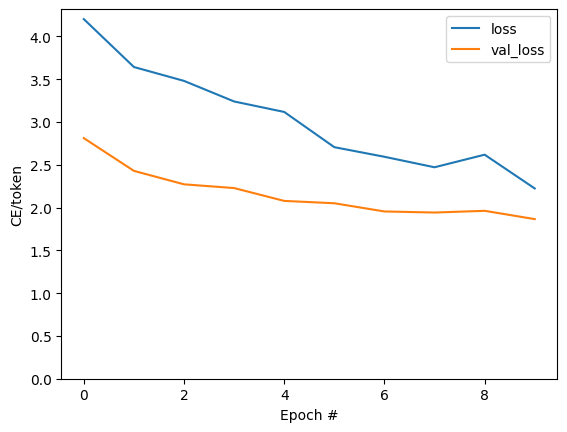

In [222]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

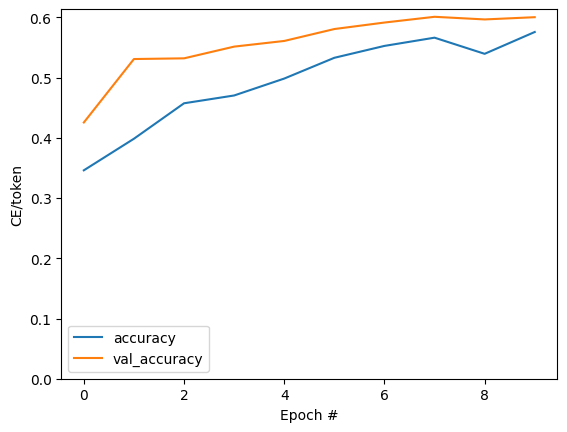

In [223]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [224]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [226]:
result = model.translate(["zip lists in python"])
result[0].numpy().decode()

'[UNK] '

In [227]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output Command')

C:\Users\brije\AppData\Local\Temp\ipykernel_46284\43034453.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\brije\AppData\Local\Temp\ipykernel_46284\43034453.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


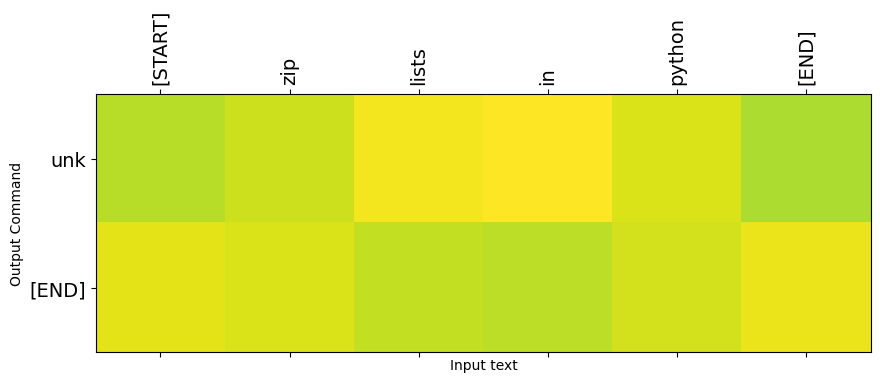

In [228]:
model.plot_attention('zip lists in python') 

In [229]:
with open('conala-corpus/conala-test.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

test_intent_list = []
for i in range(len(obj)):
    test_intent_list.append(obj[i]['intent'])


test_snipet_list = []
for i in range(len(obj)):
    test_snipet_list.append(obj[i]['snippet'])


In [236]:
predicted=[]
actual=[]
for i in range(len(test_intent_list)):
    prediction = model.translate([test_intent_list[i]])
    prediction = prediction[0].numpy().decode()
    predicted.append(prediction)
    target_vals=test_snipet_list[i]
    actual.append(target_vals)

In [237]:
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu 
print(corpus_bleu([[i] for i in actual], predicted))

0.024951541874113404


In [233]:
import collections
import math


def _get_ngrams(segment, max_order):
  """Extracts all n-grams upto a given maximum order from an input segment.
  Args:
    segment: text segment from which n-grams will be extracted.
    max_order: maximum length in tokens of the n-grams returned by this
        methods.
  Returns:
    The Counter containing all n-grams upto max_order in segment
    with a count of how many times each n-gram occurred.
  """
  ngram_counts = collections.Counter()
  for order in range(1, max_order + 1):
    for i in range(0, len(segment) - order + 1):
      ngram = tuple(segment[i:i+order])
      ngram_counts[ngram] += 1
  return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
  """Computes BLEU score of translated segments against one or more references.
  Args:
    reference_corpus: list of lists of references for each translation. Each
        reference should be tokenized into a list of tokens.
    translation_corpus: list of translations to score. Each translation
        should be tokenized into a list of tokens.
    max_order: Maximum n-gram order to use when computing BLEU score.
    smooth: Whether or not to apply Lin et al. 2004 smoothing.
  Returns:
    3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
    precisions and brevity penalty.
  """
  matches_by_order = [0] * max_order
  possible_matches_by_order = [0] * max_order
  reference_length = 0
  translation_length = 0
  for (references, translation) in zip(reference_corpus,
                                       translation_corpus):
    reference_length += min(len(r) for r in references)
    translation_length += len(translation)

    merged_ref_ngram_counts = collections.Counter()
    for reference in references:
      merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
    translation_ngram_counts = _get_ngrams(translation, max_order)
    overlap = translation_ngram_counts & merged_ref_ngram_counts
    for ngram in overlap:
      matches_by_order[len(ngram)-1] += overlap[ngram]
    for order in range(1, max_order+1):
      possible_matches = len(translation) - order + 1
      if possible_matches > 0:
        possible_matches_by_order[order-1] += possible_matches

  precisions = [0] * max_order
  for i in range(0, max_order):
    if smooth:
      precisions[i] = ((matches_by_order[i] + 1.) /
                       (possible_matches_by_order[i] + 1.))
    else:
      if possible_matches_by_order[i] > 0:
        precisions[i] = (float(matches_by_order[i]) /
                         possible_matches_by_order[i])
      else:
        precisions[i] = 0.0

  if min(precisions) > 0:
    p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
    geo_mean = math.exp(p_log_sum)
  else:
    geo_mean = 0

  ratio = float(translation_length) / reference_length

  if ratio > 1.0:
    bp = 1.
  else:
    bp = math.exp(1 - 1. / ratio)

  bleu = geo_mean * bp

  return (bleu, precisions, bp, ratio, translation_length, reference_length)


In [234]:
bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(actual, predicted, max_order=4,smooth=False)

In [235]:
print(bleu, precisions, bp, ratio, translation_length, reference_length)

0.0 [0.16666666666666666, 0.0, 0.0, 0.0] 1.0 7.2 36 5


In [130]:
import pandas as pd
length_df = pd.DataFrame({'intent': train_intent_list, 'snipet': train_snipet_list})

In [ ]:
length_df.hist(bins = 30)
plt.show()

In [136]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [135]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)